In [41]:
from notebook.services.config import ConfigManager
cm = ConfigManager()

cm.update('livereveal', {
              'width': 1000,
              'height': 500,
              'scroll': True,
})

{'width': 1000, 'height': 500, 'scroll': True}

# Thomas Adams - Colorado Optimization Project

## Colorado analysis to determine most suitable place to live
## Optimized around several features:
- Distance from the West mountain range
- Distance from Lockheed Martin Space Campus (40km is currently set)
- Within a user defined distance from a fitness area/gym (30km is currently set)
- Each town's net change in population to identify a rapidly growing area


## Import packages

In [7]:
# library to handle requests
import requests
# library for data analsysis
import pandas as pd
# library
import wikipedia as wp
import numpy as np
import folium
from pandas.io.json import json_normalize
import json
from IPython.display import display
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
# import plotting
from matplotlib import pyplot as plt
# import GEO data API
from geopy.geocoders import Nominatim
import geopy.distance
import time
import pickle
import os


## Data Formatting:
- Create latitude and longitude columns within the dataFrame
- Drop unecessary columns
- Drop entries without data


#### Function: Take the WGS84 format and get rid of unecessary characters
#### Function: Split the WGS84 column into individual latitude and longitude columns

In [8]:
def format_lat_lon(wgs84_str):
    lat_lon = wgs84_str.split(" / ")[1]
    
    lat_str = lat_lon.split(" ")[0]
    lat = float(lat_str[1:-3]) if lat_str[-1] is 'N' else float(lat_str[1:-3])*-1
    
    lon_str = lat_lon.split(" ")[1]
    lon = float(lon_str[:-3]) if lon_str[-1] is 'E' else float(lon_str[:-3])*-1
    
    return [lat,lon]

In [9]:
def format_data(areas_of_interest):
    
    # take lat / lon str from wiki page -> seperate lat / lon as numerical types
    areas_of_interest['Latitude'] = areas_of_interest['WGS84'].apply(lambda x : format_lat_lon(x)[0])
    areas_of_interest['Longitude'] = areas_of_interest['WGS84'].apply(lambda x : format_lat_lon(x)[1])

    # select the columns with useful data
    areas_of_interest = areas_of_interest[['Place Name','Change','Latitude','Longitude']]
    areas_of_interest = areas_of_interest.dropna(subset=['Change']).reset_index(drop=True)

    return areas_of_interest


## Load the data:
#### Wikipedia Page: https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Colorado
    - % Population increase, city list, WGS84 (lat, lon)
####  .GOV Page: https://demography.dola.colorado.gov/population/population-totals-municipalities/
    - Median age / demographic data
#### Foursquare API: https://developer.foursquare.com/
    - Venues/ammenities
    - Radius of 1000m (0.62mi) with a limit of 100 venues per city

#### Grab all the venue data for each city in colorado. 
    - Radius 1000m (0.62mi), limit of 100 venues per city.

In [10]:
def get_near_by_venues(names, latitudes, longitudes, radius=1000):
    radius = 1000
    LIMIT = 100

    # Foursquare API Credentials
    CLIENT_ID = '1RAZZUPP43HZQWU5GVPVQMW3SJMCAISY40PU1HKUADFKQE5Y' # your Foursquare ID
    CLIENT_SECRET = 'XJHXGVLZNXIFJVEUMBJPN14P0EU0X3ZSKNSUKYUBTZY4YENR' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version

    print('Your credentails:')
    print('CLIENT_ID: ' + CLIENT_ID)
    print('CLIENT_SECRET:' + CLIENT_SECRET)
    venues_list=[]

    count = 0
    for name, lat, lng in zip(names, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
            
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'Dist_Latitude', 
                  'Dist_Longitude', 
                  'Venue', 
                  'Venue_Lat', 
                  'Venue_Long', 
                  'Venue_Category']
    count += 1
    if count > 15:
        time.sleep(50) 
        count = 0
        
    return (nearby_venues)

#### Scrape Colorado data from the wikipedia page
#### Demographic data from .gov
#### Venue data for every city

In [11]:
def load_format_data():
    # get cities in colorado
    html = wp.page("List_of_cities_and_towns_in_Colorado").html().encode("UTF-8")
    areas_of_interest = pd.read_html(html)[0]
    areas_of_interest.to_csv('wiki_colorado_3.csv',index=False)

    areas_of_interest = pd.read_csv('optimize_city/wiki_colorado_5.csv')
    
    # format data from wiki 
    areas_of_interest = format_data(areas_of_interest)
      
    # get demographic in colorado for every city
    median_age = pd.read_excel('optimize_city/PopulationByAge_co.xlsx')
    
        
    # get venue data for every city
    file_name = 'saved_venues.pkl'
    if os.path.isfile(file_name):
        print('Reading from saved venue data')
        venues = pd.read_pickle(file_name)    
    else:
        venues = get_near_by_venues(names=areas_of_interest['Place Name'],
                                    latitudes=areas_of_interest['Latitude'],
                                    longitudes=areas_of_interest['Longitude'])
        venues.to_pickle(file_name)
    
    return areas_of_interest, venues, median_age

## Collecting Data:
#### From the data that was loaded and formated, compute features to optimize on

#### Function that determines if a fitness center is close based on the euclidean distance between the two locations

In [12]:
def gym_close(locations, venues):
# Function to know if gym location 
# is within max dist: True or False

    # set up return data frame
    gym_close = pd.DataFrame(columns =['Place Name', 'Gym Dist'])
    gym_close['Place Name'] = locations['Place Name']
    gym_close['Gym Dist'] = 1000 
        
        
    gym_venues = venues[venues['Venue_Category'].str.contains('Gym')].reset_index(drop=True)
    gym_venues.index = np.arange(1, len(gym_venues)+1)

    for place_ndx in range(gym_close['Place Name'].shape[0]):
        place = gym_close.loc[place_ndx,'Place Name']
        place_lat_lon = (locations.loc[place_ndx, 'Latitude'],locations.loc[place_ndx, 'Longitude'])

        dist_to_gyms = gym_venues.apply(lambda row: \
                         geopy.distance.distance(place_lat_lon,\
                                                 (row['Venue_Lat'], row['Venue_Long'])), axis=1).astype(str).str[:-3].astype(float)

        closest_gym = gym_venues[dist_to_gyms == min(dist_to_gyms)]

        # replace gym dist (defaulted 1000) with the venue gym dist (accurate)
        gym_close.loc[place_ndx,'Gym Dist'] = min(dist_to_gyms)

    return gym_close


### Calculate Distances: https://geopy.readthedocs.io/en/stable/
    - Using the GeoPy library


In [13]:
def gather_feature_data(areas_of_interest, venues, gym_max_dist, work_max_dist):    

    real_proj = pd.DataFrame()
    real_proj['Place Name'] = areas_of_interest['Place Name']
    real_proj['Latitude'] = areas_of_interest['Latitude']
    real_proj['Longitude'] = areas_of_interest['Longitude']
    real_proj['population change'] = areas_of_interest['Change']
    real_proj['population change'] = real_proj['population change'].apply(lambda x: float(str(x).strip('%')))
    real_proj['population change'] = real_proj['population change'].apply(lambda x: float(str(x).strip('+')))

    #dist to west
    idaho_springs_ndx = areas_of_interest['Place Name'] == "Idaho Springs" 
    idaho_springs_lat_lon = (areas_of_interest['Latitude'][idaho_springs_ndx].values[0],\
                             areas_of_interest['Longitude'][idaho_springs_ndx].values[0])

    real_proj['dist from west']=areas_of_interest.apply(lambda row: \
                                           geopy.distance.distance(idaho_springs_lat_lon,\
                                           (row['Latitude'], row['Longitude'])), axis=1).astype(str).str[:-3].astype(float)

    # dist to work / within x miles
    waterton_campus = (39.4935996, -105.0885975)
    real_proj['dist from work']=areas_of_interest.apply(lambda row: \
                                           geopy.distance.distance(waterton_campus,\
                                           (row['Latitude'], row['Longitude'])), axis=1)

    real_proj['close to work']=real_proj['dist from work'] < work_max_dist 

    # dist to gym / within x miles
    gym_data = gym_close(areas_of_interest,venues)
    real_proj['dist from gym'] = gym_data['Gym Dist']
    real_proj['close to gym'] = real_proj['dist from gym'] < gym_max_dist 
    
    return real_proj


## Algorithm Development: 
### Determine the most suitable place to live based on the features passed into the machine learning algorithm


$$
\begin{array}{c}
f(w_{k}) = \frac{w_{1}}{distance_{west}} + w_{2}{0 \choose 1} + w_{3}{0 \choose 1} + w_{4}population_{change}
\end{array}
$$

In [14]:
def calculate_rating_lambda(location_features):
    
    # calculate weights for each location
    weight_dist = 300
    weight_work = 50
    weight_demo = 1
    weight_gym = 15
    weight_pop_change = 0.0425
    
    # ideal location (idaho springs) will divide by 0
    try:
        dist_score = (weight_dist/location_features['dist from west'])
    except:
        dist_score = 50
        
    work_score = (weight_work if location_features['close to work'] else 0)
    gym_score = (weight_gym if location_features['close to gym'] else 0)
    pop_change_score = (weight_pop_change * location_features['population change'])
    
    tot_score = dist_score + work_score + gym_score + pop_change_score 
    
    return tot_score
              
def calculate_rating(location_features):
    
    location_features['rating'] = location_features.apply(lambda row: calculate_rating_lambda(row), axis=1)      
    location_features = location_features.sort_values(by=['rating'], ascending=False).reset_index(drop=True)        
               
    return location_features
    

## Run the optimization

#### Define the optimizer function on the data

In [15]:
def optimize():
    
    max_dist_gym = 30
    max_dist_work = 40
       
    #load and format needed data
    areas_of_interest, venues, median_age = load_format_data()

    # collects data for optimization features
    location_features = gather_feature_data(areas_of_interest, venues, max_dist_gym, max_dist_work)
    
    # calculate the rating for each city based on the optimization function
    optimized_features = calculate_rating(location_features)
    
    return optimized_features

#### Call the optimizer function

In [16]:
colorado_cities_ranked = optimize()
print('\nOptimization function selected ' + colorado_cities_ranked.loc[0,'Place Name'] + ' as the highest rated city in Colorado')

print('The shape of the ratings dataframe is {}'.format(colorado_cities_ranked.shape))
colorado_cities_ranked.head(20)

Reading from saved venue data

Optimization function selected Golden as the highest rated city in Colorado
The shape of the ratings dataframe is (260, 10)


,Place Name,Latitude,Longitude,population change,dist from west,dist from work,close to work,dist from gym,close to gym,rating
0,Golden,39.742483,-105.210561,7.07,25.225771,29.550838737662627 km,True,9.460412,True,77.193075
1,Morrison,39.625613,-105.207919,0.70,28.910792,17.887989456477833 km,True,17.848111,True,75.406498
2,Arvada,39.833728,-105.150306,6.71,31.786643,38.13328146462501 km,True,0.954634,True,74.723102
3,Lakewood,39.698942,-105.117551,4.66,33.658545,22.9337683946409 km,True,7.756865,True,74.111091
4,Wheat Ridge,39.772675,-105.104801,2.88,34.374113,31.016278877256084 km,True,0.514579,True,73.849898
5,Edgewater,39.750820,-105.062615,2.30,37.894329,28.645511952330438 km,True,0.322237,True,73.014502
6,Mountain View,39.774776,-105.056711,5.08,38.500246,31.33812762277209 km,True,0.458953,True,73.008058
7,Bow Mar,39.626594,-105.050914,6.35,41.232627,15.116828285299205 km,True,4.631732,True,72.545667
8,Central City,39.795790,-105.514835,9.20,5.274778,49.64101014162365 km,False,6.126827,True,72.265436
9,Sheridan,39.647757,-105.017457,5.03,43.278086,18.17438871137402 km,True,1.442374,True,72.145690


## Visualizations

#### Using a mapping package called Folium(): https://python-visualization.github.io/folium/

#### Mapping function

In [17]:
def color_producer(rating, use_color_map):
    if not use_color_map:
        return 'blue'
    if rating < 20:
        return 'red'
    elif 20 <= rating < 50:
        return 'yellow'
    else:
        return 'green'
    
def create_map_view(co_municipality, use_color_rating):
    address = 'Denver, CO'

    geolocator = Nominatim(user_agent="denver_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude

    # create map of resulting co_municipality
    map_co = folium.Map(location=[latitude, longitude], zoom_start=11, tiles="openstreetmap", 
                             attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

    for lat, lng, rating, place_name in zip(co_municipality['Latitude'], co_municipality['Longitude'], co_municipality['rating'], co_municipality['Place Name']):
        label = '{}'.format(place_name)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
                [lat, lng],
                radius=5,
                popup=label,
                color= color_producer(rating, use_color_rating),
                fill=True,
                fill_color= color_producer(rating, use_color_rating),
                fill_opacity=0.7,
                parse_html=False).add_to(map_co)

    if use_color_rating:
        top_choice = co_municipality.loc[0]
        folium.Marker([top_choice['Latitude'], top_choice['Longitude']],
              popup=top_choice['Place Name'],
              icon=folium.Icon(color='green',icon='info')
              ).add_to(map_co)
    return map_co

#### Call mapping function on all the cities of Colorado

In [18]:
create_map_view(colorado_cities_ranked, False)

#### Color code the map to show optimal, sub-optimal and least optimal locations based off the ranking algorithm

In [19]:
create_map_view(colorado_cities_ranked, True)

# Extra:
    - Use Kmeans to group cities based off how similar their respective venues/ammenities are
## Additional interesting insights/visualizations


In [20]:
# Call getNearbyVenues on my areas of interest
areas_of_interest,denver_msa_venues,_ = load_format_data()


Reading from saved venue data


In [21]:
# print shape of the venues df
print ("Shape of the Venues Dataframe: ", denver_msa_venues.shape)
denver_msa_venues.head()

Shape of the Venues Dataframe:  (3495, 7)


,District,Dist_Latitude,Dist_Longitude,Venue,Venue_Lat,Venue_Long,Venue_Category
0,Aguilar,37.403626,-104.655036,Ringo's Market & Deli,37.402332,-104.653080,Market
1,Akron,40.164382,-103.220685,akron fairgrounds,40.160296,-103.219846,Racetrack
2,Akron,40.164382,-103.220685,Chalet Cafe and Lounge,40.159090,-103.212673,American Restaurant
3,Akron,40.164382,-103.220685,five stars restaurant,40.158778,-103.212854,Comfort Food Restaurant
4,Akron,40.164382,-103.220685,Akron Airport,40.171453,-103.213999,Airport


In [22]:
# Create a df out of all denver venues to concentrate only on Gym / Fitness 

denver_msa_venues_only_gym = denver_msa_venues[denver_msa_venues['Venue_Category']\
                                                          .str.contains('Gym')].reset_index(drop=True)
denver_msa_venues_only_gym.index = np.arange(1, len(denver_msa_venues_only_gym)+1)
print ("Shape of the dataFrame with Venue Category as Gym: ", denver_msa_venues_only_gym.shape)
denver_msa_venues_only_gym.head()

Shape of the dataFrame with Venue Category as Gym:  (65, 7)


,District,Dist_Latitude,Dist_Longitude,Venue,Venue_Lat,Venue_Long,Venue_Category
1,Alamosa,37.475041,-105.875314,Rex Gym,37.473224,-105.880822,Gym
2,Arvada,39.833728,-105.150306,Apex Swimming Pool,39.825838,-105.145876,Gym Pool
3,Arvada,39.833728,-105.150306,Apex Gym,39.825838,-105.145728,Gym / Fitness Center
4,Aspen,39.194951,-106.837002,Resnik-Malek Health Center,39.202745,-106.831536,Gym / Fitness Center
5,Basalt,39.358174,-107.018557,Roaring Fork Dining Room,39.356063,-107.015678,Gym


In [23]:
# funtion for map
def createMapViewVenues(co_municipality):
    address = 'Denver, CO'

    geolocator = Nominatim(user_agent="denver_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of Denver is {}, {}.'.format(latitude, longitude))

    # create map of resulting co_municipality
    gym_map_restaurants = folium.Map(location=[latitude, longitude], zoom_start=10, tiles="openstreetmap", 
                            attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

    # add markers to the map
    # markers_colors = []
    for lat, lon, cat, distric in zip(co_municipality['Venue_Lat'], 
                                      co_municipality['Venue_Long'], 
                                      co_municipality['Venue_Category'], 
                                      co_municipality['District']):
        label = folium.Popup(str(cat) + ' ' + str(distric), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=3,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.3,
            parse_html=False).add_to(gym_map_restaurants)


    return gym_map_restaurants

In [24]:
createMapViewVenues(denver_msa_venues_only_gym)

The geograpical coordinate of Denver is 39.7392364, -104.9848623.


In [25]:
#createMapViewVenues(denver_msa_venues)

### What are the 15 most common venues in the state of Colorado

In [26]:
# create a dataframe of top 15 categories in Colorado.
Denver_Venues_Top15 = denver_msa_venues['Venue_Category'].value_counts()[0:15].to_frame(name='Frequency')
Denver_Venues_Top15= Denver_Venues_Top15.reset_index()


Denver_Venues_Top15.rename(index=str, columns={"index": "Venue_Category", "Frequency": "Frequency"}, inplace=True)
Denver_Venues_Top15

,Venue_Category,Frequency
0,American Restaurant,171
1,Hotel,139
2,Mexican Restaurant,139
3,Coffee Shop,138
4,Pizza Place,128
5,Fast Food Restaurant,103
6,Sandwich Place,89
7,Park,84
8,Convenience Store,81
9,Bar,75


## Bar graph

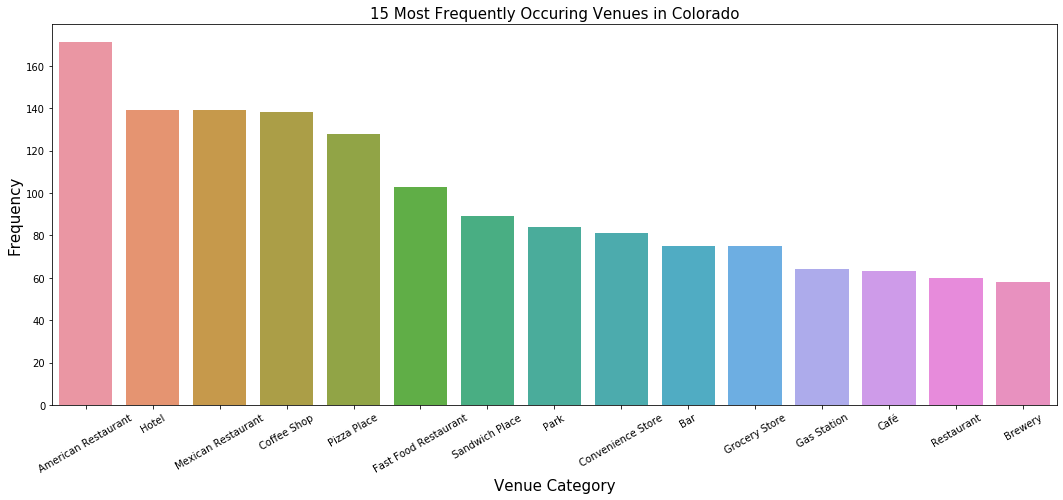

In [27]:
# plot the most common venues in Colorado.

import seaborn as sns
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue_Category", y="Frequency", data=Denver_Venues_Top15)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('15 Most Frequently Occuring Venues in Colorado', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues.png", dpi=300)
plt.show()

In [28]:
# df_boulder = areas_of_interest[areas_of_interest['Municipality'] == 'City of Boulder']
# df_castle = areas_of_interest[areas_of_interest['Municipality'] == 'Town of Castle Rock']
# df_lone = areas_of_interest[areas_of_interest['Municipality'] == 'City of Lone Tree']

# top left corner of bounding box
ndx_of_intrest_boulder = areas_of_interest['Place Name'] == 'Boulder'
boulder_lat = areas_of_interest['Latitude'][ndx_of_intrest_boulder].values[0]
boulder_lon = areas_of_interest['Longitude'][ndx_of_intrest_boulder].values[0]

# bottom right corner of bounding box
ndx_of_intrest_parker = areas_of_interest['Place Name'] == 'Parker'
parker_lat = areas_of_interest['Latitude'][ndx_of_intrest_parker].values[0]
parker_lon = areas_of_interest['Longitude'][ndx_of_intrest_parker].values[0]


idx_lat = np.logical_and(areas_of_interest['Latitude'] <= boulder_lat, areas_of_interest['Latitude'] >= parker_lat)
idx_lon = np.logical_and(areas_of_interest['Longitude'] >= boulder_lon, areas_of_interest['Longitude'] <= parker_lon)
areas_of_interest_filtered = areas_of_interest[np.logical_and(idx_lat, idx_lon)].reset_index(drop=True)

def create_map_view2(co_municipality):
    address = 'Denver, CO'

    geolocator = Nominatim(user_agent="denver_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude

    # create map of resulting co_municipality
    map_co = folium.Map(location=[latitude, longitude], zoom_start=11, tiles="openstreetmap", 
                             attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

    for lat, lng, place_name in zip(co_municipality['Latitude'], co_municipality['Longitude'], co_municipality['Place Name']):
        label = '{}'.format(place_name)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
                [lat, lng],
                radius=5,
                popup=label,
                color= 'Blue',
                fill=True,
                fill_color= 'Blue',
                fill_opacity=0.7,
                parse_html=False).add_to(map_co)

    return map_co

create_map_view2(areas_of_interest_filtered)

## Preparing data for ML algorithm
#### Change the catergorical variables to numerical values

In [29]:
# Going to use one hot encoding (dummy variables)
# One hot encoding is a process by which categorical variables are converted into a form /
# that ML algorithms can understand.
denver_msa_venues_onehot = pd.get_dummies(denver_msa_venues[['Venue_Category']], prefix="", prefix_sep="")
# add the district, column back in and make first column.
denver_msa_venues_onehot['District'] = denver_msa_venues['District']
fixed_columns = [denver_msa_venues_onehot.columns[-1]] + list(denver_msa_venues_onehot.columns[:-1])
denver_msa_venues_onehot = denver_msa_venues_onehot[fixed_columns]
# print
print(denver_msa_venues_onehot.shape)
denver_msa_venues_onehot.head()

(3495, 319)


,District,ATM,Accessories Store,Adult Boutique,Airport,Airport Gate,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Aguilar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Akron,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Akron,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,Akron,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Akron,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Calculate the mean of each venue within each district

In [30]:
# Grab the mean of each venue within each district.
# Group the df by District.
denver_msa_venues_grouped = denver_msa_venues_onehot.groupby('District').mean().reset_index()
print(denver_msa_venues_grouped.shape)
denver_msa_venues_grouped.head()

(228, 319)


,District,ATM,Accessories Store,Adult Boutique,Airport,Airport Gate,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Aguilar,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Akron,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Alamosa,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Alma,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Antonito,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Top 15 Venues per area

In [31]:
# Top 15 venues per area.
num_top_venues = 15
for hood in denver_msa_venues_grouped['District']:
    print('-----'+hood+'-----')
    temp = denver_msa_venues_grouped[denver_msa_venues_grouped['District'] == hood].T.reset_index()
    temp.columns = ['Venue', 'Frequency']
    temp = temp.iloc[1:]
    temp['Frequency'] = temp['Frequency'].astype(float)
    temp = temp.round({'Frequency': 2})
    print(temp.sort_values('Frequency', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')


-----Aguilar-----
                            Venue  Frequency
0                          Market        1.0
1           Performing Arts Venue        0.0
2                       Pawn Shop        0.0
3                         Parking        0.0
4                            Park        0.0
5   Paper / Office Supplies Store        0.0
6           Outdoors & Recreation        0.0
7            Outdoor Supply Store        0.0
8               Other Repair Shop        0.0
9                 Organic Grocery        0.0
10                            ATM        0.0
11                    Opera House        0.0
12                         Office        0.0
13        North Indian Restaurant        0.0
14                   Noodle House        0.0


-----Akron-----
                            Venue  Frequency
0                         Airport       0.25
1                       Racetrack       0.25
2             American Restaurant       0.25
3         Comfort Food Restaurant       0.25
4                  

                            Venue  Frequency
0            Fast Food Restaurant       0.27
1                      Truck Stop       0.09
2                     Coffee Shop       0.09
3             American Restaurant       0.09
4                  Sandwich Place       0.09
5                Business Service       0.09
6                             Gym       0.09
7                   Grocery Store       0.09
8                    Liquor Store       0.09
9                             ATM       0.00
10                        Parking       0.00
11                           Park       0.00
12  Paper / Office Supplies Store       0.00
13          Outdoors & Recreation       0.00
14           Outdoor Supply Store       0.00


-----Black Hawk-----
                    Venue  Frequency
0                  Casino       0.48
1              Restaurant       0.10
2     American Restaurant       0.10
3             Coffee Shop       0.06
4              Steakhouse       0.06
5              Donut Shop       0.0

                    Venue  Frequency
0          Discount Store       0.14
1          Sandwich Place       0.14
2               BBQ Joint       0.14
3             Pizza Place       0.14
4            Home Service       0.14
5            Liquor Store       0.14
6                     Bar       0.14
7             Opera House       0.00
8            Noodle House       0.00
9   Performing Arts Venue       0.00
10              Pawn Shop       0.00
11                Parking       0.00
12              Nightclub       0.00
13         Nightlife Spot       0.00
14                   Park       0.00


-----Campo-----
                            Venue  Frequency
0                       BBQ Joint        0.5
1                            Park        0.5
2              Persian Restaurant        0.0
3           Performing Arts Venue        0.0
4                       Pawn Shop        0.0
5                         Parking        0.0
6   Paper / Office Supplies Store        0.0
7           Outdoors & Recreat

                      Venue  Frequency
0                   Theater       0.17
1               Pizza Place       0.17
2                      Food       0.08
3                      Café       0.08
4            History Museum       0.08
5   Comfort Food Restaurant       0.08
6        Mexican Restaurant       0.08
7                       Bar       0.08
8                Taco Place       0.08
9             Garden Center       0.08
10              Opera House       0.00
11             Optical Shop       0.00
12          Organic Grocery       0.00
13                   Office       0.00
14  North Indian Restaurant       0.00


-----Crested Butte-----
                   Venue  Frequency
0    American Restaurant       0.05
1                   Park       0.05
2            Gas Station       0.04
3                    Bar       0.04
4            Pizza Place       0.04
5     Mexican Restaurant       0.04
6         Breakfast Spot       0.04
7                  Hotel       0.04
8            Coffee Shop  

                            Venue  Frequency
0                           Hotel        0.2
1                      Truck Stop        0.2
2                     Coffee Shop        0.2
3                  Sandwich Place        0.2
4               Electronics Store        0.2
5               Other Repair Shop        0.0
6                       Pawn Shop        0.0
7                         Parking        0.0
8                            Park        0.0
9   Paper / Office Supplies Store        0.0
10          Outdoors & Recreation        0.0
11           Outdoor Supply Store        0.0
12                            ATM        0.0
13                Organic Grocery        0.0
14             Persian Restaurant        0.0


-----Eagle-----
                            Venue  Frequency
0                            Pool        0.2
1          Furniture / Home Store        0.2
2                         Dog Run        0.2
3                     Golf Course        0.2
4                      Bike Trail    

                            Venue  Frequency
0      Construction & Landscaping        0.4
1                 Automotive Shop        0.2
2                     IT Services        0.2
3                    Liquor Store        0.2
4               Other Repair Shop        0.0
5           Performing Arts Venue        0.0
6                       Pawn Shop        0.0
7                         Parking        0.0
8                            Park        0.0
9   Paper / Office Supplies Store        0.0
10          Outdoors & Recreation        0.0
11           Outdoor Supply Store        0.0
12                            ATM        0.0
13            Peruvian Restaurant        0.0
14                Organic Grocery        0.0


-----Fowler-----
                         Venue  Frequency
0                        Diner        0.1
1               Baseball Field        0.1
2                   Restaurant        0.1
3            Convenience Store        0.1
4   Construction & Landscaping        0.1
5        

14                      Bookstore       0.02


-----Glenwood Springs-----
                         Venue  Frequency
0                        Hotel       0.10
1           Mexican Restaurant       0.07
2                  Coffee Shop       0.06
3               Ice Cream Shop       0.04
4          American Restaurant       0.04
5                          Bar       0.03
6                      Brewery       0.03
7               Sandwich Place       0.03
8          Fried Chicken Joint       0.03
9                    Bookstore       0.03
10                  Hot Spring       0.03
11                 Gas Station       0.03
12            Asian Restaurant       0.03
13                  Theme Park       0.01
14  Tourist Information Center       0.01


-----Golden-----
                     Venue  Frequency
0           Sandwich Place       0.11
1              Coffee Shop       0.06
2              Golf Course       0.06
3                    Trail       0.06
4           Shipping Store       0.06
5      

                            Venue  Frequency
0                            Bank       0.14
1             American Restaurant       0.14
2                            Café       0.14
3                   Grocery Store       0.14
4               Convenience Store       0.14
5              Mexican Restaurant       0.14
6                  Discount Store       0.14
7                     Opera House       0.00
8           Outdoors & Recreation       0.00
9              Persian Restaurant       0.00
10          Performing Arts Venue       0.00
11                      Pawn Shop       0.00
12                        Parking       0.00
13                           Park       0.00
14  Paper / Office Supplies Store       0.00


-----Jamestown-----
                            Venue  Frequency
0                            Café        1.0
1                             ATM        0.0
2                          Resort        0.0
3                       Pawn Shop        0.0
4                         Parking

                   Venue  Frequency
0                 Bakery       0.05
1            Coffee Shop       0.05
2                Brewery       0.05
3    Rental Car Location       0.04
4                   Park       0.04
5      Convenience Store       0.04
6                Theater       0.04
7            Pizza Place       0.04
8                   Bank       0.04
9     Chinese Restaurant       0.04
10            Restaurant       0.04
11   American Restaurant       0.04
12                Bistro       0.02
13  Fast Food Restaurant       0.02
14         Deli / Bodega       0.02


-----Louisville-----
                            Venue  Frequency
0                            Park       0.25
1                           Trail       0.25
2                   Moving Target       0.25
3                    Tennis Court       0.25
4                     Opera House       0.00
5   Paper / Office Supplies Store       0.00
6           Outdoors & Recreation       0.00
7            Outdoor Supply Store       0

                            Venue  Frequency
0             American Restaurant        1.0
1                             ATM        0.0
2                 Organic Grocery        0.0
3                       Pawn Shop        0.0
4                         Parking        0.0
5                            Park        0.0
6   Paper / Office Supplies Store        0.0
7           Outdoors & Recreation        0.0
8            Outdoor Supply Store        0.0
9               Other Repair Shop        0.0
10                   Optical Shop        0.0
11             Persian Restaurant        0.0
12                    Opera House        0.0
13                         Office        0.0
14        North Indian Restaurant        0.0


-----Ouray-----
                  Venue  Frequency
0                 Hotel       0.23
1               Brewery       0.09
2   American Restaurant       0.09
3             Gift Shop       0.09
4                   Pub       0.06
5         Deli / Bodega       0.03
6       Thai Rest

                            Venue  Frequency
0            Herbs & Spices Store       0.33
1                      Restaurant       0.33
2                 Bed & Breakfast       0.33
3                             ATM       0.00
4                 Organic Grocery       0.00
5                         Parking       0.00
6                            Park       0.00
7   Paper / Office Supplies Store       0.00
8           Outdoors & Recreation       0.00
9            Outdoor Supply Store       0.00
10              Other Repair Shop       0.00
11                   Optical Shop       0.00
12          Performing Arts Venue       0.00
13                    Opera House       0.00
14                         Office       0.00


-----Seibert-----
                            Venue  Frequency
0                     Flower Shop       0.33
1                      Campground       0.33
2             American Restaurant       0.33
3               Other Repair Shop       0.00
4           Performing Arts Venue  

                            Venue  Frequency
0                 Supplement Shop        0.5
1               Food & Drink Shop        0.5
2                  Rental Service        0.0
3                         Parking        0.0
4                            Park        0.0
5   Paper / Office Supplies Store        0.0
6           Outdoors & Recreation        0.0
7            Outdoor Supply Store        0.0
8               Other Repair Shop        0.0
9                 Organic Grocery        0.0
10                   Optical Shop        0.0
11                    Opera House        0.0
12                         Office        0.0
13        North Indian Restaurant        0.0
14                   Noodle House        0.0


-----Wellington-----
                   Venue  Frequency
0            Gas Station       0.14
1   Fast Food Restaurant       0.09
2          Grocery Store       0.09
3            Pizza Place       0.09
4                    Bar       0.05
5                Brewery       0.05
6    

## Sort venues by how frequent they are in each city

In [32]:
# function to sort venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
# create new dataframe and display the top 10 venues for each district.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
district_venues_sorted = pd.DataFrame(columns = columns)
district_venues_sorted['District'] = denver_msa_venues_grouped['District']

for ind in np.arange(denver_msa_venues_grouped.shape[0]):
    district_venues_sorted.iloc[ind, 1:] = return_most_common_venues(denver_msa_venues_grouped.iloc[ind, :], num_top_venues)

district_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aguilar,Market,Gas Station,Fishing Store,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service
1,Akron,Racetrack,Airport,American Restaurant,Comfort Food Restaurant,Zoo,Food Service,Flea Market,Flower Shop,Fondue Restaurant,Food
2,Alamosa,Fast Food Restaurant,Pizza Place,Coffee Shop,Breakfast Spot,Grocery Store,Mexican Restaurant,Gym,Park,Golf Course,Liquor Store
3,Alma,Bar,Liquor Store,Convenience Store,Coffee Shop,Zoo,Food Court,Flea Market,Flower Shop,Fondue Restaurant,Food
4,Antonito,Train Station,Marijuana Dispensary,Motel,Grocery Store,Gas Station,Discount Store,Distillery,Food Stand,Fondue Restaurant,Disc Golf


## K-means Algorithm: http://shabal.in/visuals/kmeans/6.html
    - k-means clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster

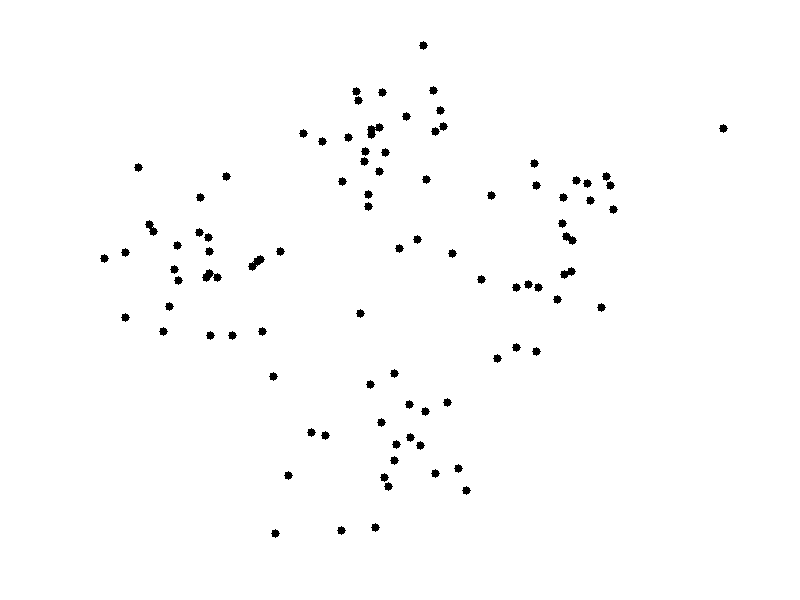

In [34]:
from IPython.display import Image
Image(filename="random.gif")

## Find the optimal amount of clusters

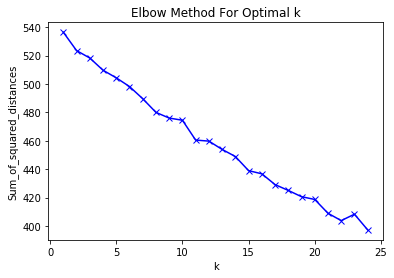

In [35]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

denver_grouped_clustering = denver_msa_venues_grouped.drop('District', 1)
mms = MinMaxScaler()
mms.fit(denver_grouped_clustering)
data_transformed = mms.transform(denver_grouped_clustering)

Sum_of_squared_distances = []
K = range(1,25)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## Run the algorithm on the data
    - Run k-means to cluster the districts into 22 clusters

In [36]:
# set number of clusters
kclusters = 22


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(denver_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:] 

array([11, 10,  1, 10,  8,  3,  3, 10, 10,  4, 10,  8,  1, 10,  6, 10, 10,
        3,  3,  3,  4,  3,  1, 13,  1,  8,  3,  1,  1, 10, 10, 10,  8, 10,
       10,  1,  3,  6,  1, 10,  1,  1,  1,  3,  1, 10, 10, 10,  4, 10,  1,
       10, 10,  3, 10,  3, 10, 10, 10, 10, 10,  1,  2, 10,  1, 10,  1,  1,
       10,  1, 10, 17,  8, 10,  1, 10, 10, 10,  1,  5,  9, 10,  1,  1, 20,
       10,  1, 10, 10, 10, 10, 10, 10, 10,  1,  0, 10,  1, 10, 19, 10, 10,
        0,  8,  1,  8, 10,  8,  6, 10, 10, 10, 12, 10,  0,  1,  8,  1, 10,
        1, 10, 10,  1,  1,  3, 10,  1, 10, 10, 14, 10, 10, 10,  3,  1, 10,
       11, 10, 10, 16, 15,  1,  4,  1, 10, 10, 10,  0,  8, 10, 10, 10, 10,
        3,  8, 21,  5,  8, 15, 10,  2, 10, 10,  2,  3, 10, 10,  2, 13, 12,
        3, 10, 10, 18,  0,  0, 10, 10,  3,  1, 14,  3,  1, 10, 10,  6, 12,
       10,  0, 10,  8, 10,  3, 10, 10, 10,  8,  1,  3, 10, 10, 10,  6, 10,
        7, 10,  1,  5, 10, 10, 10,  9, 10,  8,  3, 10,  1,  8, 10, 10,  1,
       10,  1, 10,  1, 10

In [37]:
# add clustering labels
district_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

denver_msa_venues_cluster_merged = areas_of_interest

# merge 
denver_msa_venues_cluster_merged = denver_msa_venues_cluster_merged.join \
                                        (district_venues_sorted.set_index('District'), on='Place Name')
denver_msa_venues_cluster_merged = denver_msa_venues_cluster_merged.dropna()
denver_msa_venues_cluster_merged['Cluster Labels'] = denver_msa_venues_cluster_merged['Cluster Labels'].astype(int)
denver_msa_venues_cluster_merged['Cluster Labels'].head()

0    11
1    10
2     1
3    10
4     8
Name: Cluster Labels, dtype: int64

In [38]:
# create map
den_latitude = 39.7392
den_longitude = -104.9903
map_clusters = folium.Map(location=[den_latitude, den_longitude], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(denver_msa_venues_cluster_merged['Latitude'], 
                                  denver_msa_venues_cluster_merged['Longitude'], 
                                  denver_msa_venues_cluster_merged['Place Name'], 
                                  denver_msa_venues_cluster_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Thank you for your time today!